# Lab 12 – Hyperparameter Tuning

Name: Bryce DiRisio

Class: CSCI 349 - Intro to Data Mining

Semester: 2020SP

Instructor: Brian King

The code below is needed to run this lab:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import sklearn

import time
import os

from sklearn import datasets, linear_model, tree
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier

from scipy import stats

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


### 1) Read in the wine data frame using the code given above. It also gives you the names of the variables, which should align according to the data information given on the UCI web page.

In [2]:
df_names = pd.Series(['Class','Alcohol','Malic Acid','Ash','Alcalinity of Ash','Magnesium','Total Phenols','Flavanoids','Nonflavanoid Phenols','Proanthocyanins','Color Intensity','Hue','OD280/OD315','Proline'])
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',names=df_names) 

### 2) Prepare your data. Minimally, you should be reporting:

### a) shape, info(), etc

In [3]:
df_wine.shape

(178, 14)

In [4]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Class                 178 non-null    int64  
 1   Alcohol               178 non-null    float64
 2   Malic Acid            178 non-null    float64
 3   Ash                   178 non-null    float64
 4   Alcalinity of Ash     178 non-null    float64
 5   Magnesium             178 non-null    int64  
 6   Total Phenols         178 non-null    float64
 7   Flavanoids            178 non-null    float64
 8   Nonflavanoid Phenols  178 non-null    float64
 9   Proanthocyanins       178 non-null    float64
 10  Color Intensity       178 non-null    float64
 11  Hue                   178 non-null    float64
 12  OD280/OD315           178 non-null    float64
 13  Proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


### b) describe()

In [5]:
df_wine.describe()

Class     Alcohol  Malic Acid         Ash  Alcalinity of Ash  \
count  178.000000  178.000000  178.000000  178.000000         178.000000   
mean     1.938202   13.000618    2.336348    2.366517          19.494944   
std      0.775035    0.811827    1.117146    0.274344           3.339564   
min      1.000000   11.030000    0.740000    1.360000          10.600000   
25%      1.000000   12.362500    1.602500    2.210000          17.200000   
50%      2.000000   13.050000    1.865000    2.360000          19.500000   
75%      3.000000   13.677500    3.082500    2.557500          21.500000   
max      3.000000   14.830000    5.800000    3.230000          30.000000   

        Magnesium  Total Phenols  Flavanoids  Nonflavanoid Phenols  \
count  178.000000     178.000000  178.000000            178.000000   
mean    99.741573       2.295112    2.029270              0.361854   
std     14.282484       0.625851    0.998859              0.124453   
min     70.000000       0.980000    0.340000              0.130000   
25%     88.000000       1.742500    1.205000              0.270000   
50%     98.000000       2.355000    2.135000              0.340000   
75%    107.000000       2.800000    2.875000              0.437500   
max    162.000000       3.880000    5.080000              0.660000   

       Proanthocyanins  Color Intensity         Hue  OD280/OD315      Proline  
count       178.000000       178.000000  178.000000   178.000000   178.000000  
mean          1.590899         5.058090    0.957449     2.611685   746.893258  
std           0.572359         2.318286    0.228572     0.709990   314.907474  
min           0.410000         1.280000    0.480000     1.270000   278.000000  
25%           1.250000         3.220000    0.782500     1.937500   500.500000  
50%           1.555000         4.690000    0.965000     2.780000   673.500000  
75%           1.950000         6.200000    1.120000     3.170000   985.000000  
max           3.580000        13.000000    1.710000     4.000000  1680.000000

### c) Cast the type of the variables accordingly, particularly the target class

In [6]:
df_wine.iloc[:,0] = df_wine.iloc[:,0].astype('category')
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Class                 178 non-null    category
 1   Alcohol               178 non-null    float64 
 2   Malic Acid            178 non-null    float64 
 3   Ash                   178 non-null    float64 
 4   Alcalinity of Ash     178 non-null    float64 
 5   Magnesium             178 non-null    int64   
 6   Total Phenols         178 non-null    float64 
 7   Flavanoids            178 non-null    float64 
 8   Nonflavanoid Phenols  178 non-null    float64 
 9   Proanthocyanins       178 non-null    float64 
 10  Color Intensity       178 non-null    float64 
 11  Hue                   178 non-null    float64 
 12  OD280/OD315           178 non-null    float64 
 13  Proline               178 non-null    int64   
dtypes: category(1), float64(11), int64(2)
memory usage: 18.5 K

### d) Report on any missing data

In [7]:
df_wine.isnull().sum()

Class                   0
Alcohol                 0
Malic Acid              0
Ash                     0
Alcalinity of Ash       0
Magnesium               0
Total Phenols           0
Flavanoids              0
Nonflavanoid Phenols    0
Proanthocyanins         0
Color Intensity         0
Hue                     0
OD280/OD315             0
Proline                 0
dtype: int64

As seen above, there are no 'null' values in any data attribute. We can also see in df_wine.info() that all attributes have 178 entries, and df_wine.shape[0] is 178. This further proves that there actually is no missing data in the dataset.

### e) Show the head() of the data frame

In [8]:
df_wine.head()

Class  Alcohol  Malic Acid   Ash  Alcalinity of Ash  Magnesium  \
0     1    14.23        1.71  2.43               15.6        127   
1     1    13.20        1.78  2.14               11.2        100   
2     1    13.16        2.36  2.67               18.6        101   
3     1    14.37        1.95  2.50               16.8        113   
4     1    13.24        2.59  2.87               21.0        118   

   Total Phenols  Flavanoids  Nonflavanoid Phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color Intensity   Hue  OD280/OD315  Proline  
0             5.64  1.04         3.92     1065  
1             4.38  1.05         3.40     1050  
2             5.68  1.03         3.17     1185  
3             7.80  0.86         3.45     1480  
4             4.32  1.04         2.93      735

### 3) Perform your EDA. Minimally, you should be reporting:

### a) Distributions of the target class

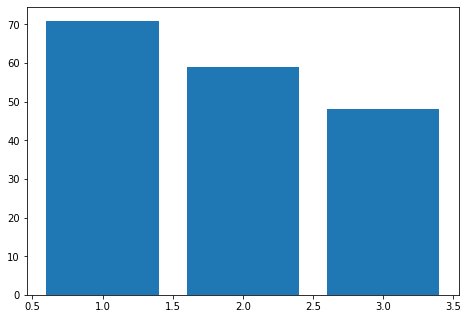

In [9]:
class_counts = df_wine.iloc[:,0].value_counts()
class_names = df_wine.iloc[:,0].unique()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(class_names,class_counts)

plt.show()

### b) Distributions of the variables

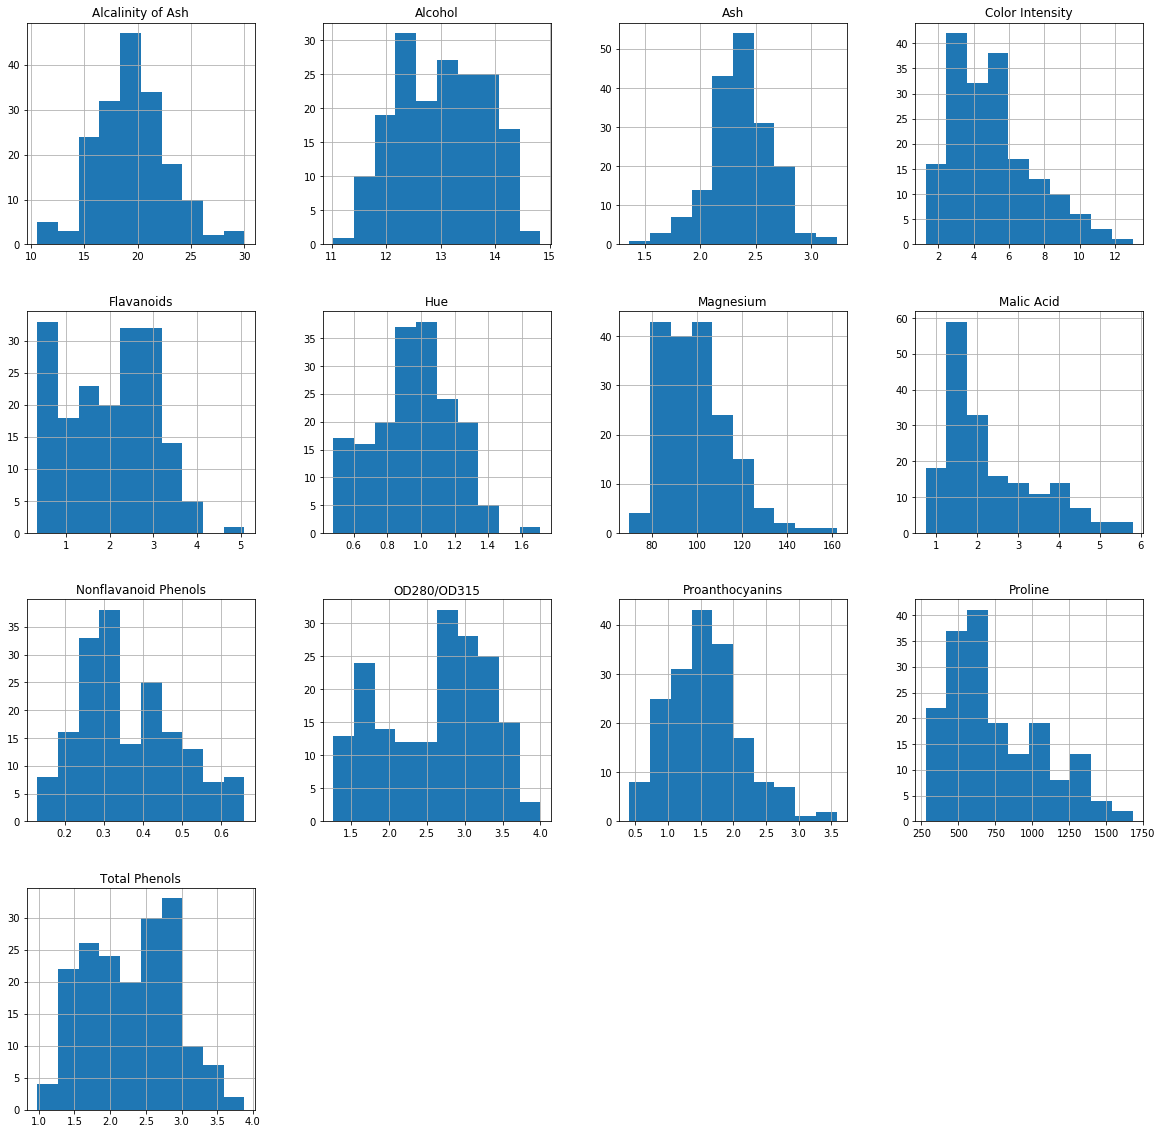

In [10]:
df_wine.hist(figsize=(20,20))

plt.show()

### c) Distributions of the variables, given each target class. Numeric and visual summaries are useful here.

In [11]:
df_wine_class1 = pd.DataFrame([df_wine.iloc[i] for i in range(df_wine.shape[0]) if df_wine.iloc[i]['Class']==1])
df_wine_class1.describe()

Class    Alcohol  Malic Acid        Ash  Alcalinity of Ash   Magnesium  \
count   59.0  59.000000   59.000000  59.000000          59.000000   59.000000   
mean     1.0  13.744746    2.010678   2.455593          17.037288  106.338983   
std      0.0   0.462125    0.688549   0.227166           2.546322   10.498949   
min      1.0  12.850000    1.350000   2.040000          11.200000   89.000000   
25%      1.0  13.400000    1.665000   2.295000          16.000000   98.000000   
50%      1.0  13.750000    1.770000   2.440000          16.800000  104.000000   
75%      1.0  14.100000    1.935000   2.615000          18.700000  114.000000   
max      1.0  14.830000    4.040000   3.220000          25.000000  132.000000   

       Total Phenols  Flavanoids  Nonflavanoid Phenols  Proanthocyanins  \
count      59.000000   59.000000             59.000000        59.000000   
mean        2.840169    2.982373              0.290000         1.899322   
std         0.338961    0.397494              0.070049         0.412109   
min         2.200000    2.190000              0.170000         1.250000   
25%         2.600000    2.680000              0.255000         1.640000   
50%         2.800000    2.980000              0.290000         1.870000   
75%         3.000000    3.245000              0.320000         2.090000   
max         3.880000    3.930000              0.500000         2.960000   

       Color Intensity        Hue  OD280/OD315      Proline  
count        59.000000  59.000000    59.000000    59.000000  
mean          5.528305   1.062034     3.157797  1115.711864  
std           1.238573   0.116483     0.357077   221.520767  
min           3.520000   0.820000     2.510000   680.000000  
25%           4.550000   0.995000     2.870000   987.500000  
50%           5.400000   1.070000     3.170000  1095.000000  
75%           6.225000   1.130000     3.420000  1280.000000  
max           8.900000   1.280000     4.000000  1680.000000

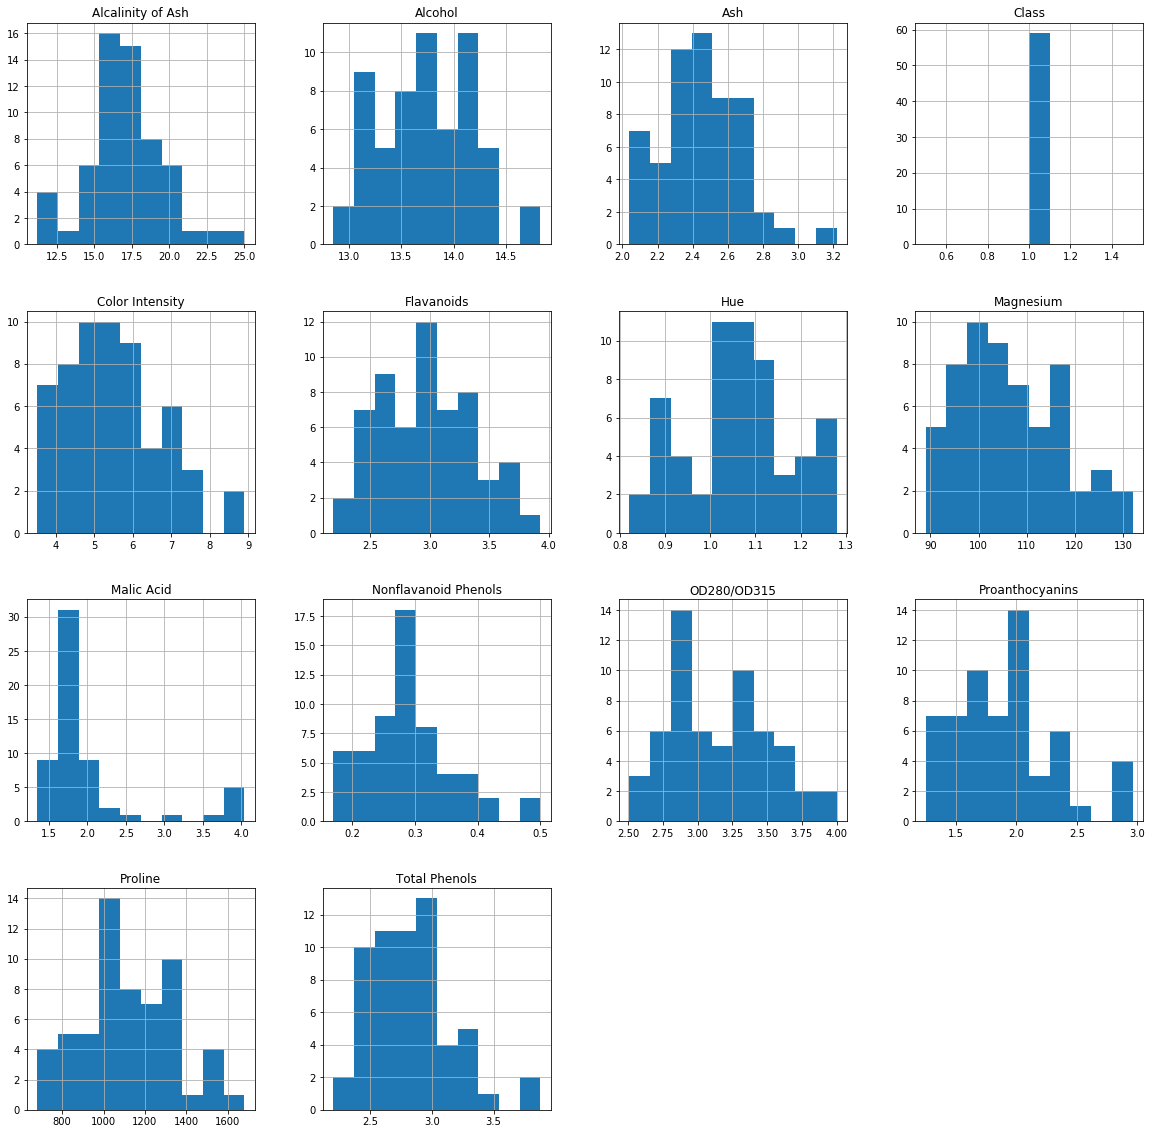

In [12]:
df_wine_class1.hist(figsize=(20,20))

plt.show()

In [13]:
df_wine_class2 = pd.DataFrame([df_wine.iloc[i] for i in range(df_wine.shape[0]) if df_wine.iloc[i]['Class']==2])
df_wine_class2.describe()

Class    Alcohol  Malic Acid        Ash  Alcalinity of Ash   Magnesium  \
count   71.0  71.000000   71.000000  71.000000          71.000000   71.000000   
mean     2.0  12.278732    1.932676   2.244789          20.238028   94.549296   
std      0.0   0.537964    1.015569   0.315467           3.349770   16.753497   
min      2.0  11.030000    0.740000   1.360000          10.600000   70.000000   
25%      2.0  11.915000    1.270000   2.000000          18.000000   85.500000   
50%      2.0  12.290000    1.610000   2.240000          20.000000   88.000000   
75%      2.0  12.515000    2.145000   2.420000          22.000000   99.500000   
max      2.0  13.860000    5.800000   3.230000          30.000000  162.000000   

       Total Phenols  Flavanoids  Nonflavanoid Phenols  Proanthocyanins  \
count      71.000000   71.000000             71.000000        71.000000   
mean        2.258873    2.080845              0.363662         1.630282   
std         0.545361    0.705701              0.123961         0.602068   
min         1.100000    0.570000              0.130000         0.410000   
25%         1.895000    1.605000              0.270000         1.350000   
50%         2.200000    2.030000              0.370000         1.610000   
75%         2.560000    2.475000              0.430000         1.885000   
max         3.520000    5.080000              0.660000         3.580000   

       Color Intensity        Hue  OD280/OD315     Proline  
count        71.000000  71.000000    71.000000   71.000000  
mean          3.086620   1.056282     2.785352  519.507042  
std           0.924929   0.202937     0.496573  157.211220  
min           1.280000   0.690000     1.590000  278.000000  
25%           2.535000   0.925000     2.440000  406.500000  
50%           2.900000   1.040000     2.830000  495.000000  
75%           3.400000   1.205000     3.160000  625.000000  
max           6.000000   1.710000     3.690000  985.000000

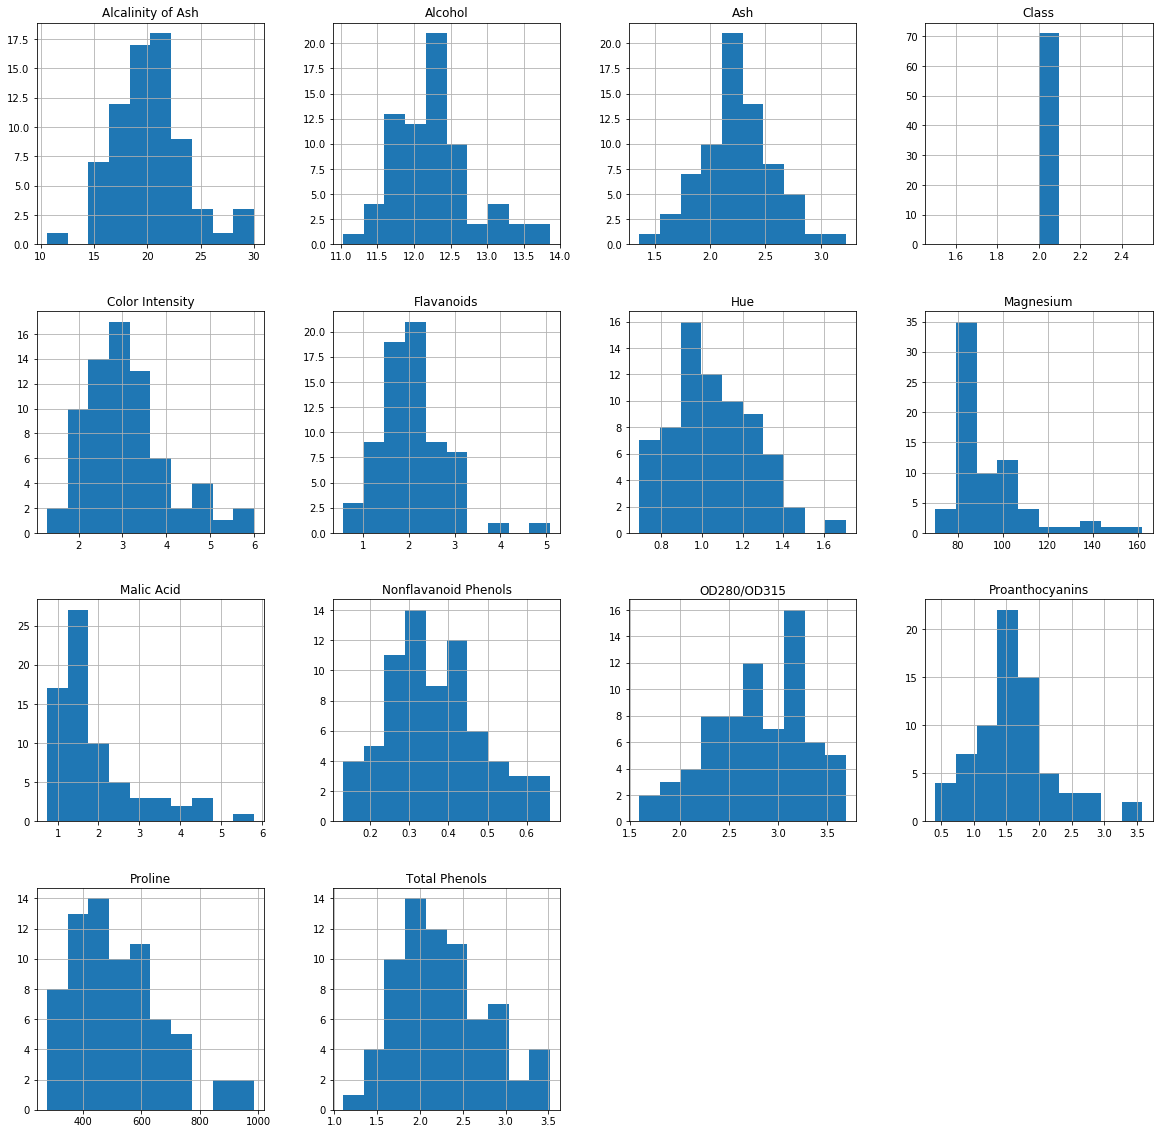

In [14]:
df_wine_class2.hist(figsize=(20,20))

plt.show()

In [15]:
df_wine_class3 = pd.DataFrame([df_wine.iloc[i] for i in range(df_wine.shape[0]) if df_wine.iloc[i]['Class']==3])
df_wine_class3.describe()

Class    Alcohol  Malic Acid        Ash  Alcalinity of Ash   Magnesium  \
count   48.0  48.000000   48.000000  48.000000          48.000000   48.000000   
mean     3.0  13.153750    3.333750   2.437083          21.416667   99.312500   
std      0.0   0.530241    1.087906   0.184690           2.258161   10.890473   
min      3.0  12.200000    1.240000   2.100000          17.500000   80.000000   
25%      3.0  12.805000    2.587500   2.300000          20.000000   89.750000   
50%      3.0  13.165000    3.265000   2.380000          21.000000   97.000000   
75%      3.0  13.505000    3.957500   2.602500          23.000000  106.000000   
max      3.0  14.340000    5.650000   2.860000          27.000000  123.000000   

       Total Phenols  Flavanoids  Nonflavanoid Phenols  Proanthocyanins  \
count      48.000000   48.000000              48.00000        48.000000   
mean        1.678750    0.781458               0.44750         1.153542   
std         0.356971    0.293504               0.12414         0.408836   
min         0.980000    0.340000               0.17000         0.550000   
25%         1.407500    0.580000               0.39750         0.855000   
50%         1.635000    0.685000               0.47000         1.105000   
75%         1.807500    0.920000               0.53000         1.350000   
max         2.800000    1.570000               0.63000         2.700000   

       Color Intensity        Hue  OD280/OD315     Proline  
count        48.000000  48.000000    48.000000   48.000000  
mean          7.396250   0.682708     1.683542  629.895833  
std           2.310942   0.114441     0.272111  115.097043  
min           3.850000   0.480000     1.270000  415.000000  
25%           5.437500   0.587500     1.510000  545.000000  
50%           7.550000   0.665000     1.660000  627.500000  
75%           9.225000   0.752500     1.820000  695.000000  
max          13.000000   0.960000     2.470000  880.000000

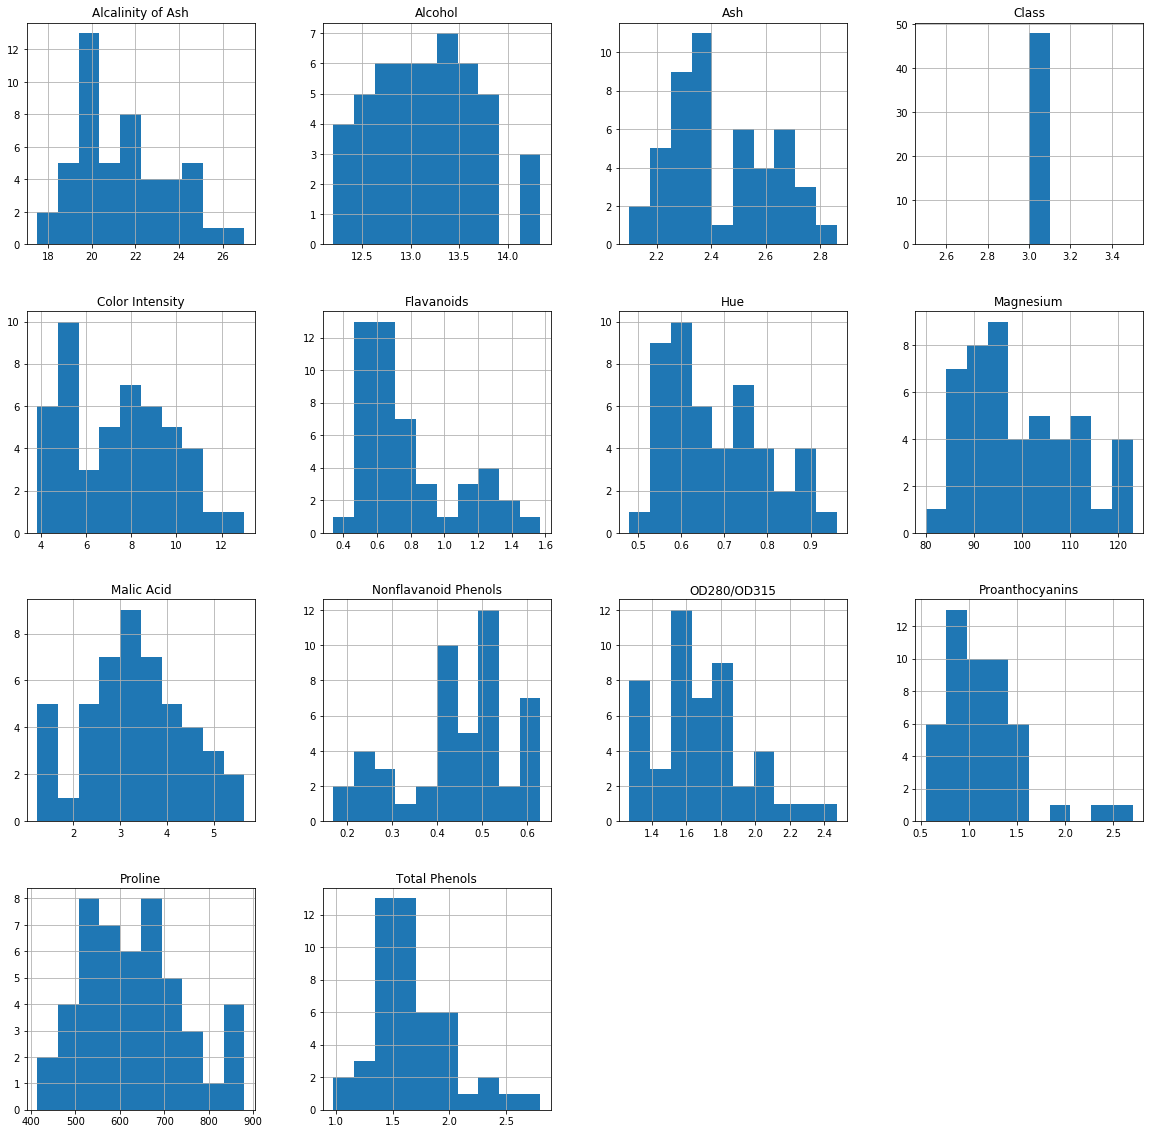

In [16]:
df_wine_class3.hist(figsize=(20,20))

plt.show()

### 4) Set up your X and y data frames to prepare for your modeling steps. Be sure to standardize your X variables. Create a binarized version of y as well. (Remember, this is important for classifiers such as neural nets when you are working with a target variable that is multi-class (i.e. more than two labels). And, again, it's very important that you shuffle your data.

In [17]:
df_noClass = df_wine.drop('Class',axis=1)
y = pd.DataFrame(df_wine.iloc[:,0])

df_noClass, y = shuffle(df_noClass,y)

X = stats.zscore(df_noClass)
y = pd.get_dummies(y)

5) Let's induce a basic Decision Tree Classifier (i.e. DecisionTreeClassifier()). Don't set any initial parameters. Let the default tree induction parameters be used. Evaluate the tree using a 5-fold cross validation. Perform a standard report of your class-wide performance metrics (i.e. using classification report, but specify 3 significant digits instead of the default of 2). You should have all of this code completed from a previous lab.

In [18]:
k = 5
df_results = []
df_pred = []
df_X = pd.DataFrame(X)

for train_i, test_i in KFold(n_splits=k, shuffle=True).split(df_wine):
    X_train = df_X.iloc[train_i]
    y_train = y.iloc[train_i]
    X_test = df_X.iloc[test_i]
    y_test = y.iloc[test_i]
    
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    
    y_pred = pd.DataFrame(clf.predict(X_test))
    #rename columns for classification_report
    y_pred = y_pred.rename(columns={0:"Class_1",1:"Class_2",2:"Class_3"})
    
    y_pred = list(y_pred.idxmax(axis=1))
    y_test = list(y_test.idxmax(axis=1))
    
    df_results += y_test
    df_pred += y_pred
    
print('Done')

Done


### What is the overall accuracy? Which class performs the best? The worst?

In [19]:
print(classification_report(df_results, df_pred))

              precision    recall  f1-score   support

     Class_1       0.93      0.92      0.92        59
     Class_2       0.89      0.92      0.90        71
     Class_3       0.91      0.90      0.91        48

    accuracy                           0.91       178
   macro avg       0.91      0.91      0.91       178
weighted avg       0.91      0.91      0.91       178



In [20]:
print('Overall Accuracy: {}'.format(round(accuracy_score(df_results,df_pred),2)))

Overall Accuracy: 0.91


Looking at the classification report above, we can see that 'Class_2' has the weakest performance with a precision of '0.89'. In contrast, 'Class_1' had the strongest performance with a precision of '0.93'.

### 6) Try to run your code above a few different times. Your performance results should fluctuate a bit. Why?

Performance results are fluctuating significantly such that highest, lowest, and total accuracy are changing each time. This can be attributed to the decision tree clsasifier used to fit our data. In the decision tree classifier, it may choose apply split boundries to the data at different axis values. Depending on how the data is spread out, the location of these boundaries could mostly encapsulate one class of data and split through another class of data, or vice versa. By changing these boundaries (each time its run), we would see differing accuracy results in the report.

### 7) As we learned, a decision tree has a lot of parameters. Likewise, the DecisionTreeClassifier class offers those parameters for you to affect your tree induction. Let's introduce GridSearchCV , a fantastic framework to find good hyperparameters for your models. There are TWO important parameters to GridSearchCV:
### a) estimator – this is the model that you will evaluate, that implements the scikit-learn estimator interface (which is pretty much every model implemented in scikit-learn!)
### b) param_grid – this is a dictionary with parameters of your model as keys, and a list of values to test as the value of each key.
### Add the provided param_grid dictionary, then execute your code

In [21]:
param_grid = {
    'criterion':['gini', 'entropy'], 
    'max_depth':[3,4,5,6,7]
}

In [22]:
grid = GridSearchCV(DecisionTreeClassifier(),
                    param_grid,
                    return_train_score=True,
                    cv=5)
grid_result = grid.fit(X,y)

### 8) Cool! Now, you need to explore the internal attributes of grid_result. It contains a LOT of information. Look closely at the description of the return value on the documentation page for GridSearchCV. Then, show the best score, along with the best parameters for that score. (HINT best_score_ and best_params_)

In [23]:
print("The best score is: {}".format(round(grid_result.best_score_, 2)))

The best score is: 0.95


In [24]:
print("The best parameters for that score are with the {} criterion and a depth of {}".format(grid_result.best_params_['criterion'],format(grid_result.best_params_['max_depth'])))

The best parameters for that score are with the entropy criterion and a depth of 5


### 9) [M] What does the best "score" represent? What performance metric? How do you override it, if, for example, you want to use f1_macro?

The best score represents an accuracy function, which is derived from the mean 'score' achieved by whichever tested estimator gave the highest 'score'/smallest loss (as determined by the best_estimator_ attribute). The default performance metric that is used by this method is the estimator's score method. To override it, there is a 'scoring' parameter in GridSearchCV that can change the scoring metric.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

### 10) Write the code to report the mean training and testing score and standard deviation for every parameter combination tested. Output your data in order of highest mean test score to lowest.

In [25]:
#get data
df_results = pd.DataFrame(grid_result.cv_results_)

#set up columns
df_params = df_results.loc[:,'params']
df_mean_training = df_results.loc[:,'mean_train_score']
df_mean_testing = df_results.loc[:,'mean_test_score']
df_std_train = df_results.loc[:,'std_train_score']
df_std_test = df_results.loc[:,'std_test_score']

#form final table
df_final = pd.DataFrame()
df_final['params']=df_params
df_final['mean_training']=df_mean_training
df_final['std_training']=df_std_train
df_final['mean_testing']=df_mean_testing
df_final['std_testing']=df_std_test

#sort mean testing scores
df_final.sort_values(by='mean_testing',ascending=False)

params  mean_training  std_training  \
7  {'criterion': 'entropy', 'max_depth': 5}       0.997203      0.005594   
8  {'criterion': 'entropy', 'max_depth': 6}       1.000000      0.000000   
9  {'criterion': 'entropy', 'max_depth': 7}       1.000000      0.000000   
5  {'criterion': 'entropy', 'max_depth': 3}       0.987363      0.012904   
6  {'criterion': 'entropy', 'max_depth': 4}       0.992987      0.008861   
0     {'criterion': 'gini', 'max_depth': 3}       0.990180      0.007139   
3     {'criterion': 'gini', 'max_depth': 6}       1.000000      0.000000   
2     {'criterion': 'gini', 'max_depth': 5}       1.000000      0.000000   
4     {'criterion': 'gini', 'max_depth': 7}       1.000000      0.000000   
1     {'criterion': 'gini', 'max_depth': 4}       0.997193      0.003438   

   mean_testing  std_testing  
7      0.949524     0.020712  
8      0.943968     0.024675  
9      0.943968     0.024675  
5      0.938571     0.047758  
6      0.932857     0.041345  
0      0.921429     0.010754  
3      0.910317     0.026745  
2      0.899365     0.061912  
4      0.899365     0.061912  
1      0.893810     0.072852

### 11) The default scoring parameter is accuracy, and you've already learned about how accuracy is not necessarily the best metric on unbalanced data. This data is only slightly unbalanced, thus it is not a bad metric. However, you should understand how to choose a better scoring metric to identify the best results for these data. In general, a macro-averaged f1 metric is a pretty good assessment of classifier performance when you have unbalanced data, as it will give you an honest assessment of how you are doing on the smallest classes. Redo the above steps, but you must accomplish three things:
### a) Add min_samples_split and min_samples_leaf criteria to your grid search. Choose the parameter values that make sense to you.
### b) Specify the scoring parameter to use both accuracy AND f1_macro. You'll likely also need to specify the refit parameter. (Look these up! Don't just blindly do what I'm telling you to do without understanding!)
### c) Change your result to a full 10-fold cross validation. This could take some time, but gives a better assessment of the power of your classifier. Perhaps using 5 fold just wasn't quite enough data for each member?
### Again, output your results, showing the top five configurations by accuracy, and also by f1_macro. Comment on your results.

In [26]:
param_grid_new = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,4,5,6,7],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2,3]
}

grid = GridSearchCV(DecisionTreeClassifier(),
                    param_grid_new,
                    return_train_score=True,
                    cv=10,
                    scoring=['accuracy','f1_macro'],
                    refit=False)
grid_result = grid.fit(X,y)

#get data
df_results = pd.DataFrame(grid_result.cv_results_)

#form final table
df_final = pd.DataFrame()
df_final['params']=df_results.loc[:,'params']
df_final['mean_training_f1_macro']=df_results.loc[:,'mean_train_f1_macro']
df_final['std_training_f1_macro']=df_results.loc[:,'std_train_f1_macro']
df_final['mean_testing_f1_macro']=df_results.loc[:,'mean_test_f1_macro']
df_final['std_testing_f1_macro']=df_results.loc[:,'std_test_f1_macro']
df_final['mean_training_accuracy']=df_results.loc[:,'mean_train_accuracy']
df_final['std_training_accuracy']=df_results.loc[:,'std_train_accuracy']
df_final['mean_testing_accuracy']=df_results.loc[:,'mean_test_accuracy']
df_final['std_testing_accuracy']=df_results.loc[:,'std_test_accuracy']

#sort mean testing scores
df_final_f1_macro_sorted = df_final.sort_values(by=['mean_testing_f1_macro'],ascending=False).head(5)
df_final_accuracy_sorted = df_final.sort_values(by=['mean_testing_accuracy'],ascending=False).head(5)

In [27]:
display(df_final_f1_macro_sorted)

params  mean_training_f1_macro  \
69  {'criterion': 'entropy', 'max_depth': 5, 'min_...                0.990728   
82  {'criterion': 'entropy', 'max_depth': 7, 'min_...                0.998581   
54  {'criterion': 'entropy', 'max_depth': 4, 'min_...                0.996983   
72  {'criterion': 'entropy', 'max_depth': 6, 'min_...                1.000000   
66  {'criterion': 'entropy', 'max_depth': 5, 'min_...                0.992142   

    std_training_f1_macro  mean_testing_f1_macro  std_testing_f1_macro  \
69               0.007330               0.948050              0.063075   
82               0.002839               0.946383              0.050776   
54               0.004863               0.946383              0.050776   
72               0.000000               0.944247              0.054675   
66               0.005207               0.943453              0.056241   

    mean_training_accuracy  std_training_accuracy  mean_testing_accuracy  \
69                0.988758               0.010004               0.944444   
82                0.997500               0.005000               0.944444   
54                0.995625               0.007421               0.944444   
72                1.000000               0.000000               0.944444   
66                0.985016               0.008931               0.938889   

    std_testing_accuracy  
69              0.070273  
82              0.055556  
54              0.055556  
72              0.055556  
66              0.067814

In [28]:
display(df_final_accuracy_sorted)

params  mean_training_f1_macro  \
54  {'criterion': 'entropy', 'max_depth': 4, 'min_...                0.996983   
69  {'criterion': 'entropy', 'max_depth': 5, 'min_...                0.990728   
82  {'criterion': 'entropy', 'max_depth': 7, 'min_...                0.998581   
72  {'criterion': 'entropy', 'max_depth': 6, 'min_...                1.000000   
74  {'criterion': 'entropy', 'max_depth': 6, 'min_...                0.997647   

    std_training_f1_macro  mean_testing_f1_macro  std_testing_f1_macro  \
54               0.004863               0.946383              0.050776   
69               0.007330               0.948050              0.063075   
82               0.002839               0.946383              0.050776   
72               0.000000               0.944247              0.054675   
74               0.003669               0.941316              0.060720   

    mean_training_accuracy  std_training_accuracy  mean_testing_accuracy  \
54                0.995625               0.007421               0.944444   
69                0.988758               0.010004               0.944444   
82                0.997500               0.005000               0.944444   
72                1.000000               0.000000               0.944444   
74                0.996250               0.006374               0.938889   

    std_testing_accuracy  
54              0.055556  
69              0.070273  
82              0.055556  
72              0.055556  
74              0.067814

Looking at the tables above, we see that mean_testing_f1_macro achieved a scoring high of 0.94805, and mean_testing_accuracy achieved a scoring high of 0.944444. With this, it looks that the mean_testing_f1_macro was able to achieve very slightly higher results compared to accuracy. However, this was ran a few times and there was fluxuation involved in both values such that I would not CONCLUDE this to be the case. More variables could be at play to further distinguish the two methods.

### 12) [M] Discuss your findings. Did 10-fold make a difference? Did the additional parameters make a difference? Output the top 5 parameter configurations, along with the training and testing, sorted by accuracy, then sorted by f1_macro. Summarize.

Looking at the two tables above, it seems that performing 10 folds hasn't made a huge difference in the data. Our standard deviataion values did not seem to have any discernable difference between the two trials. However, including more parameters did seem to help further narrow down our parameter conditions. By doing so, it helped us to fine tune how our classifier works to yield higher scoring values for mean testing. Looking at the results above, we see that our top performing metric seems to be the following:

In [42]:
df_sorted_top = df_final.sort_values(by=['mean_testing_accuracy','mean_testing_f1_macro'],ascending=False).head(1)
display(df_sorted_top)
print(df_sorted_top.iloc[0,0])

params  mean_training_f1_macro  \
69  {'criterion': 'entropy', 'max_depth': 5, 'min_...                0.990728   

    std_training_f1_macro  mean_testing_f1_macro  std_testing_f1_macro  \
69                0.00733                0.94805              0.063075   

    mean_training_accuracy  std_training_accuracy  mean_testing_accuracy  \
69                0.988758               0.010004               0.944444   

    std_testing_accuracy  
69              0.070273

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}


The parameter here has the 'entropy' criterion, a max node depth of 5, a minimum of 3 leaf node samples, and a minimum of 2 samples to split a node.

### 13) Most of you should have some sort of multicore processor, even on the simplest laptops. You can easily take advantage of this. The default configuration of GridSearchCV is to NOT use any parallel processing, thus evaluating one model at a time. However, you could perhaps do 2 at a time! Do you have a CPU with more than 1 core? (Yes, you most likely do!) Redo the above, but try out the parameter n_jobs=2 (I also sometimes set pre_dispatch to the same number as n_jobs, just to control too much memory usage. Not really important for decision trees, but could be important for larger models. If you have a really juicy machine, try an even higher value of n_jobs).

### *Work laptop has i7 chip --> 4 cores:

In [30]:
grid_1 = GridSearchCV(DecisionTreeClassifier(),
                          param_grid_new,
                          return_train_score=True,
                          cv=10,
                          scoring=['accuracy','f1_macro'],
                          refit=False,
                          n_jobs = 1, pre_dispatch=1)
start_t = time.time()
grid_1.fit(X,y)
final_t = time.time()-start_t
print("One core took {} seconds".format(round(final_t, 2)))

One core took 8.5 seconds


In [31]:
grid_2 = GridSearchCV(DecisionTreeClassifier(),
                          param_grid_new,
                          return_train_score=True,
                          cv=10,
                          scoring=['accuracy','f1_macro'],
                          refit=False,
                          n_jobs = 2, pre_dispatch=2)
start_t = time.time()
grid_2.fit(X,y)
final_t = time.time()-start_t
print("Two cores took {} seconds".format(round(final_t, 2)))

Two cores took 6.81 seconds


In [32]:
grid_3 = GridSearchCV(DecisionTreeClassifier(),
                          param_grid_new,
                          return_train_score=True,
                          cv=10,
                          scoring=['accuracy','f1_macro'],
                          refit=False,
                          n_jobs = 3, pre_dispatch=3)
start_t = time.time()
grid_3.fit(X,y)
final_t = time.time()-start_t
print("Three cores took {} seconds".format(round(final_t, 2)))

Three cores took 5.02 seconds


In [33]:
grid_4 = GridSearchCV(DecisionTreeClassifier(),
                          param_grid_new,
                          return_train_score=True,
                          cv=10, scoring=['accuracy','f1_macro'],
                          refit=False,
                          n_jobs = 4, pre_dispatch=4)
start_t = time.time()
grid_4.fit(X,y)
final_t = time.time()-start_t
print("Four cores took {} seconds".format(round(final_t,2)))

Four cores took 3.29 seconds


### 14) OK. Now on to hyperparameter tuning for Keras. (CONSIDER YOURSELF WARNED! Neural nets take a long time to train compared to decision trees!) From the previous lab, copy over your code for the function create_keras_model(). Now, modify your base neural net structure to match the inputs and outputs for the wine dataset you are working on for this lab. Modify the parameters of your function to allow you to pass model parameters of interest. In particular, you are going to want to evaluate a different optimizer and activation values for the hidden layer, and vary the number of hidden units. Modify your function to take these three additional parameters. You may name the parameters whatever you want, though generally it's good to keep them the same as the actual parameters used as you build your model. Once you have your new function, create your Keras classifier with KerasClassifier(). When you call this function, this is where you pass parameters such as epochs and batch_size. You don't want to wait long, so just use epochs=5 and a batch_size=4. (I would advise starting with verbose=1, just to make sure your model is training properly, and you notice the accuracy increasing and loss decreasing, then set verbose=0 when doing a bigger grid search on the next step.) Test out your KerasClassifier() instance with the cross_val_predict() method you learned about in the previous lab, and print the results of classification_report. You can try to vary some parameters if you want, but don't spend a lot of time here.

In [34]:
def create_keras_model(activation, optimizer, hidden_units):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(13,)))
    model.add(Activation(activation))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

k = 5
df_results = []
df_pred = []
df_X = pd.DataFrame(X)

for train_i, test_i in KFold(n_splits=k, shuffle=True).split(df_wine):
    X_train = df_X.iloc[train_i]
    y_train = y.iloc[train_i]
    X_test = df_X.iloc[test_i]
    y_test = y.iloc[test_i]
    
    # Create a wrapped keras model
    clf = KerasClassifier(build_fn=create_keras_model,
                      verbose=0,
                      epochs=5,
                      batch_size=4,
                      optimizer = 'adam',
                      activation = 'relu',
                      hidden_units = 10)    
    
    clf.fit(X_train, y_train)
    
    #formatting and getting/converting indices to use in classification_report
    y_pred = pd.Series(clf.predict(X_test))
    y_pred = y_pred.tolist() 
    y_test = y_test.rename(columns={"Class_1":0,"Class_2":1,"Class_3":2})
    y_test = pd.DataFrame(y_test).idxmax(axis=1) #class
    
    df_results += list(y_test)
    df_pred += list(y_pred)
    
print('Done')
print(classification_report(df_results,df_pred))

Done
              precision    recall  f1-score   support

           0       0.84      0.69      0.76        59
           1       0.83      0.76      0.79        71
           2       0.70      0.94      0.80        48

    accuracy                           0.79       178
   macro avg       0.79      0.80      0.79       178
weighted avg       0.80      0.79      0.79       178



### 15) Use GridSearchCV on Keras (and prepare to wait several minutes!) First, create a param_grid dictionary. You must, minimally, specify the following keys:
### a) 'optimizer' : ['adam','sgd']
### b) number of hidden units : 2 different numbers of your choice
### c) 'activation' : ['relu']
### d) 'epochs' : [5, 10]
### e) 'batch_size' : [4, 8]
### Create a new classifier, but be sure verbose=0. Then, just like you did with the decision tree, wrap that classifier model in a GridSearchCV instance. Use a cross validation of 5 (though you can try more if you want.) Report your best model hyperparameters.

In [45]:
param_grid = {
    'optimizer': ['adam','sgd'],
    'hidden_units': [5,10],
    'activation': ['relu'],
    'epochs': [5, 10],
    'batch_size': [4,8]
}

grid = GridSearchCV(KerasClassifier(build_fn=create_keras_model, verbose=0),
                    param_grid,
                    return_train_score=True,
                    cv=5,
                    refit=False)

grid_result = grid.fit(X,y)

#get data
df_results = pd.DataFrame(grid_result.cv_results_)

def get_results(dataFrame):

    #set up columns
    df_params = dataFrame.loc[:,'params']
    df_mean_training = dataFrame.loc[:,'mean_train_score']
    df_mean_testing = dataFrame.loc[:,'mean_test_score']
    df_std_train = dataFrame.loc[:,'std_train_score']
    df_std_test = dataFrame.loc[:,'std_test_score']

    #form final table
    df_final = pd.DataFrame()
    df_final['params']=df_params
    df_final['mean_training']=df_mean_training
    df_final['std_training']=df_std_train
    df_final['mean_testing']=df_mean_testing
    df_final['std_testing']=df_std_test
    return df_final.sort_values(by='mean_testing',ascending=False).head(5)

In [46]:
get_results(df_results)

params  mean_training  \
6   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.960691   
7   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.969113   
5   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.915897   
3   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.922722   
15  {'activation': 'relu', 'batch_size': 8, 'epoch...       0.924269   

    std_training  mean_testing  std_testing  
6       0.008318      0.955397     0.037611  
7       0.018055      0.943968     0.017327  
5       0.067152      0.915079     0.054387  
3       0.021452      0.904921     0.048667  
15      0.046180      0.887460     0.065378

The five rows above represent the top 5 (in descending order) parameters that yielded us the highest mean_testing score according to our function. Looking at this data, our top scoring hyperparameter settings were with a 'relu' activation function, a batch size of 4, 10 epochs, 10 hidden units, and the adam optimizer.

### 16) Study your results. Can you do even better? How close can you get to 100% accuracy on a 5- or 10-fold cross validation with Keras? Try a different activation... say... 'tanh'. Perhaps a few more hidden units? A bit larger batch size, but more epochs? See what happens....

#### Using tanh activation function:

In [47]:
param_grid = {
    'optimizer': ['adam'],
    'hidden_units': [5, 10],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'epochs': [5,10],
    'batch_size': [4, 8]
}

grid_try = GridSearchCV(KerasClassifier(build_fn=create_keras_model, verbose=0),
                        param_grid,
                        return_train_score=True,
                        cv=5,
                        refit=False)
grid_result = grid.fit(X,y)

df_grid = pd.DataFrame(grid_result.cv_results_)
get_results(df_grid)

params  mean_training  \
6   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.959313   
15  {'activation': 'relu', 'batch_size': 8, 'epoch...       0.964858   
5   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.960662   
7   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.969103   
3   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.925559   

    std_training  mean_testing  std_testing  
6       0.016724      0.949841     0.047718  
15      0.010029      0.921746     0.047855  
5       0.020126      0.921270     0.027759  
7       0.015804      0.915397     0.059494  
3       0.008435      0.876984     0.054041

#### Using 10 folds

In [48]:
param_grid = {
    'optimizer': ['adam'],
    'hidden_units': [5, 10],
    'activation': ['relu', 'sigmoid'],
    'epochs': [5,10],
    'batch_size': [4, 8]
}

grid_try = GridSearchCV(KerasClassifier(build_fn=create_keras_model, verbose=0),
                        param_grid,
                        return_train_score=True,
                        cv=10,
                        refit=False)
grid_result = grid.fit(X,y)

df_grid = pd.DataFrame(grid_result.cv_results_)
get_results(df_grid)

params  mean_training  \
6  {'activation': 'relu', 'batch_size': 4, 'epoch...       0.942421   
7  {'activation': 'relu', 'batch_size': 4, 'epoch...       0.969132   
5  {'activation': 'relu', 'batch_size': 4, 'epoch...       0.901615   
3  {'activation': 'relu', 'batch_size': 4, 'epoch...       0.917098   
2  {'activation': 'relu', 'batch_size': 4, 'epoch...       0.891963   

   std_training  mean_testing  std_testing  
6      0.013568      0.944127     0.058271  
7      0.011314      0.927619     0.057075  
5      0.068581      0.922063     0.077278  
3      0.023749      0.921905     0.047647  
2      0.055998      0.881905     0.032874

#### Increase number of hidden units

In [49]:
param_grid = {
    'optimizer': ['adam'],
    'hidden_units': [20,40],
    'activation': ['relu', 'sigmoid'],
    'epochs': [5,10],
    'batch_size': [4, 8]
}

grid_try = GridSearchCV(KerasClassifier(build_fn=create_keras_model, verbose=0),
                        param_grid,
                        return_train_score=True,
                        cv=5,
                        refit=False)
grid_result = grid.fit(X,y)

df_grid = pd.DataFrame(grid_result.cv_results_)
get_results(df_grid)

params  mean_training  \
7   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.960622   
6   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.967704   
5   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.933951   
3   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.924190   
14  {'activation': 'relu', 'batch_size': 8, 'epoch...       0.897577   

    std_training  mean_testing  std_testing  
7       0.020752      0.950000     0.044444  
6       0.015069      0.932857     0.027991  
5       0.018209      0.904603     0.028294  
3       0.030514      0.882063     0.027001  
14      0.063523      0.870635     0.034177

#### Larger batch AND more epochs

In [50]:
param_grid = {
    'optimizer': ['adam'],
    'hidden_units': [5, 10],
    'activation': ['relu', 'sigmoid'],
    'epochs': [50,100],
    'batch_size': [5, 10]
}

grid_try = GridSearchCV(KerasClassifier(build_fn=create_keras_model, verbose=0),
                        param_grid,
                        return_train_score=True,
                        cv=5,
                        refit=False)
grid_result = grid.fit(X,y)

df_grid = pd.DataFrame(grid_result.cv_results_)
get_results(df_grid)

params  mean_training  \
3   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.910086   
7   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.949463   
15  {'activation': 'relu', 'batch_size': 8, 'epoch...       0.914291   
6   {'activation': 'relu', 'batch_size': 4, 'epoch...       0.924022   
14  {'activation': 'relu', 'batch_size': 8, 'epoch...       0.854043   

    std_training  mean_testing  std_testing  
3       0.044878      0.916190     0.063350  
7       0.015585      0.887937     0.046118  
15      0.036088      0.887937     0.034654  
6       0.051708      0.882857     0.063790  
14      0.090410      0.882381     0.098493

Looking at the results above, I wasn't able to get a really significant increase by inducing any of the conditions above. However, I did notice a significant decrease in accuracy in the increase of epochs and batch size. 